# Ventricular Ectopic Beats Detection
In this notebook we are going to detect VEBs in an ecg signal using PCA and Hotelling $T^2$ statistics

In [1]:
import scipy.io as sio
from scipy.spatial.distance import mahalanobis
from matplotlib.mlab import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions

In [2]:
def find(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

## Load signal data

In [3]:
mat = sio.loadmat("data/ventricular_ectopic_beats.mat")
signalECG = mat['signalECG'][0]
samplerate = mat['samplerate'][0][0]
rPoints = mat['rPoints'][0]

L = len(signalECG)

## Segmentation of QRS-complexes

In [4]:
# Count R-peaks
numberQRS = len(rPoints)

# Segmentation window: 50 ms
steps = int(np.round(samplerate*0.05))

#  Define matrix 'QRS' for the segmented QRS complexes
QRS = np.zeros((numberQRS,2*steps+1))

# Segmentation
for k in range(numberQRS):
    i = rPoints[k]
    QRS[k,:] = signalECG[i-steps:i+steps+1]

## PCA
https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml

In [5]:
result = PCA(QRS)
score = np.sum(result.project(QRS), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The PCA class was deprecated in version 2.2.
  """Entry point for launching an IPython kernel.


## Classify VEBs with T^2 threshold
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.mahalanobis.html

In [6]:
def mahal(x, y):
    covariance_xy = np.cov(x,y, rowvar=0)
    inv_covariance_xy = np.linalg.inv(covariance_xy)
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i - xy_mean[0] for x_i in x])
    y_diff = np.array([y_i - xy_mean[1] for y_i in y])
    diff_xy = np.transpose([x_diff, y_diff])
    
    md = np.zeros((len(diff_xy)))
    for i in range(len(diff_xy)):
        md[i] = np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i]))
    return md

# Calculate T^2 in the reduced principal component space
tsqreduced = mahal(score, score)

# Define threshold
thres = 3*np.mean(tsqreduced)

# Thresholding of the T^2 vector of the reduced space
thresVec = tsqreduced
thresVec[thresVec < thres] = 0

# Indices of the detected VEBs
ind = find(thresVec, lambda x: x > 0)
VEBpoints = rPoints[ind]

## Plot results

[]

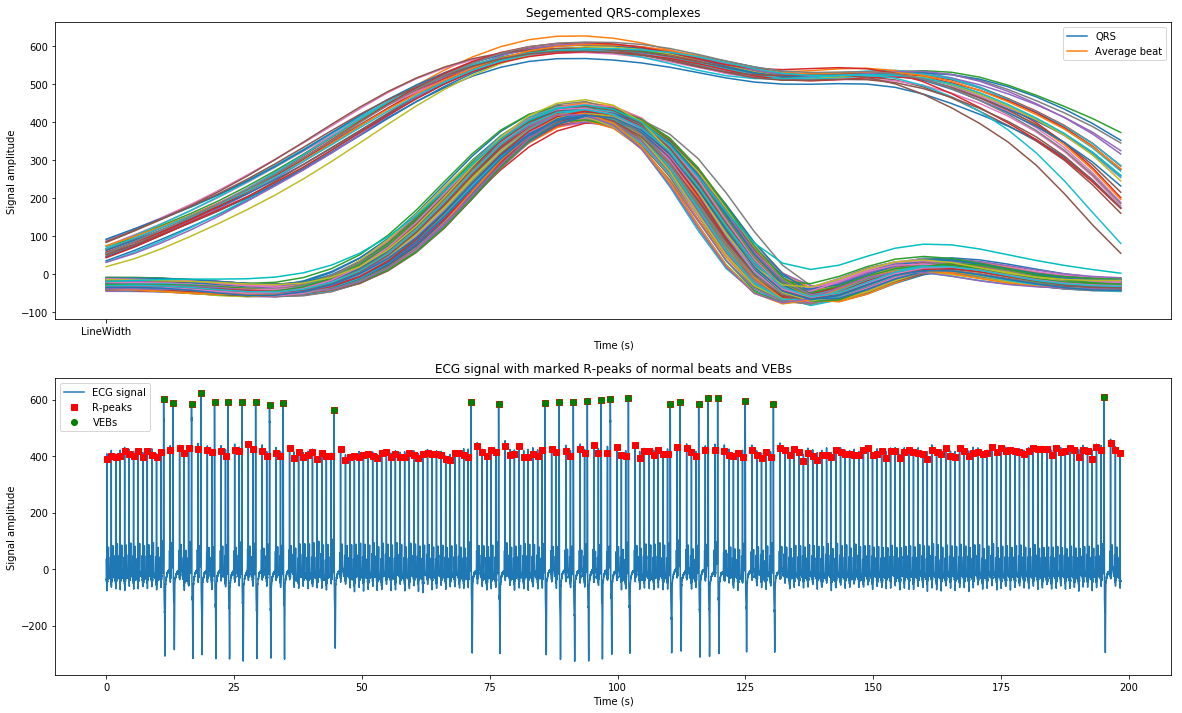

In [7]:
t = np.arange(0,L)/samplerate

plt.figure(figsize=(20, 12))

plt.subplot(2,1,1)
plt.plot(t[0:2*steps+1],QRS.T)
plt.plot(t[0:2*steps+1],np.mean(QRS, axis=0),'c','LineWidth',4)
plt.xlabel('Time (s)') 
plt.ylabel('Signal amplitude')
plt.title('Segemented QRS-complexes')
plt.legend(['QRS', 'Average beat'])

# Plot ECG signal with marked R-peaks of normal and ectopic beats
plt.subplot(2,1,2)
plt.plot(t,signalECG)
plt.plot(t[rPoints],signalECG[rPoints],'rs')
plt.plot(t[VEBpoints],signalECG[VEBpoints],'go')
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('ECG signal with marked R-peaks of normal beats and VEBs')
plt.legend(['ECG signal','R-peaks','VEBs','Location','NorthEastOutside'])
plt.plot()